# Importok

In [1]:
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
import scipy.stats as stats
import graphviz

from ucimlrepo import fetch_ucirepo
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.tree import export_graphviz
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.preprocessing import PowerTransformer, RobustScaler
from sklearn.ensemble import RandomForestClassifier
from scipy.stats import kstest
from sklearn.metrics import PrecisionRecallDisplay
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.inspection import permutation_importance
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from imblearn.over_sampling import RandomOverSampler

# Adatok letöltése

Az HTRU2 adatbázis a High Time Resolution Universe Survey során gyűjtött pulzárjelölt adatokat tartalmazza. A pulzárok gyorsan forgó neutroncsillagok, melyek rádiójelet bocsátanak ki, ezek periodikusan ismétlődnek, és földi teleszkópokkal észlelhetők. A jelöltek többsége azonban nem valódi pulzár, hanem zaj vagy rádiófrekvenciás interferencia következménye, így nehéz azonosítani a valódi pulzárokat. Az adatbázis 16259 hamis és 1639 valódi pulzár példát tartalmaz, amelyeket emberi annotátorok ellenőriztek.

In [2]:
htru2 = fetch_ucirepo(id=372)

In [3]:
X = htru2.data.features
X

,Profile_mean,Profile_stdev,Profile_skewness,Profile_kurtosis,DM_mean,DM_stdev,DM_skewness,DM_kurtosis
0,140.562500,55.683782,-0.234571,-0.699648,3.199833,19.110426,7.975532,74.242225
1,102.507812,58.882430,0.465318,-0.515088,1.677258,14.860146,10.576487,127.393580
2,103.015625,39.341649,0.323328,1.051164,3.121237,21.744669,7.735822,63.171909
3,136.750000,57.178449,-0.068415,-0.636238,3.642977,20.959280,6.896499,53.593661
4,88.726562,40.672225,0.600866,1.123492,1.178930,11.468720,14.269573,252.567306
...,...,...,...,...,...,...,...,...
17893,136.429688,59.847421,-0.187846,-0.738123,1.296823,12.166062,15.450260,285.931022
17894,122.554688,49.485605,0.127978,0.323061,16.409699,44.626893,2.945244,8.297092
17895,119.335938,59.935939,0.159363,-0.743025,21.430602,58.872000,2.499517,4.595173
17896,114.507812,53.902400,0.201161,-0.024789,1.946488,13.381731,10.007967,134.238910


In [4]:
type(X)

pandas.core.frame.DataFrame

In [5]:
feature_cimkek = list(X.columns)
feature_cimkek

['Profile_mean',
 'Profile_stdev',
 'Profile_skewness',
 'Profile_kurtosis',
 'DM_mean',
 'DM_stdev',
 'DM_skewness',
 'DM_kurtosis']

**Profile_mean** </br>
A kvazár rádiófrekvenciás profiljának átlagos intenzitása, azaz az adott hullámforma középértéke.

**Profile_stdev** </br>
A profil intenzitásának szórása, ami azt mutatja, mennyire ingadozik az érték az átlag körül.

**Profile_skewness** </br>
A profil aszimmetriáját jelzi.

**Profile_kurtosis** </br>
A profil csúcsosságát vagy laposságát mutatja az eloszlás normálishoz viszonyított alakja alapján.

**DM_mean** </br>
A diszperziós mérték (Dispersion Measure) átlagos értéke, amely megmutatja, mennyi anyagon haladt át a jel.

**DM_stdev** </br>
A diszperziós mérték szórása, azaz mennyire változó ez az érték a mérések során.

**DM_skewness** </br>
A diszperziós mérték eloszlásának aszimmetriáját mutatja, hasonlóan a profilhoz.

**DM_kurtosis** </br>
A diszperziós mérték eloszlásának csúcsosságát vagy laposságát jellemzi.

In [6]:
y = htru2.data.targets
y

,class
0,0
1,0
2,0
3,0
4,0
...,...
17893,0
17894,0
17895,0
17896,0


In [7]:
type(y)

pandas.core.frame.DataFrame

# EDA

In [8]:
X.describe()

,Profile_mean,Profile_stdev,Profile_skewness,Profile_kurtosis,DM_mean,DM_stdev,DM_skewness,DM_kurtosis
count,17898.000000,17898.000000,17898.000000,17898.000000,17898.000000,17898.000000,17898.000000,17898.000000
mean,111.079968,46.549532,0.477857,1.770279,12.614400,26.326515,8.303556,104.857709
std,25.652935,6.843189,1.064040,6.167913,29.472897,19.470572,4.506092,106.514540
min,5.812500,24.772042,-1.876011,-1.791886,0.213211,7.370432,-3.139270,-1.976976
25%,100.929688,42.376018,0.027098,-0.188572,1.923077,14.437332,5.781506,34.960504
50%,115.078125,46.947479,0.223240,0.198710,2.801839,18.461316,8.433515,83.064556
75%,127.085938,51.023202,0.473325,0.927783,5.464256,28.428104,10.702959,139.309330
max,192.617188,98.778911,8.069522,68.101622,223.392141,110.642211,34.539844,1191.000837


In [9]:
hianyzo_ertekek_X = X.isnull().sum()
hianyzo_ertekek_X

Profile_mean        0
Profile_stdev       0
Profile_skewness    0
Profile_kurtosis    0
DM_mean             0
DM_stdev            0
DM_skewness         0
DM_kurtosis         0
dtype: int64

In [10]:
y.describe()

,class
count,17898.000000
mean,0.091574
std,0.288432
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,1.000000


In [11]:
y["class"].unique()

array([0, 1])

**0-s osztály** </br>
A "zaj" vagy nem-pulzár jelek (ezekből van több).

**1-es osztály** </br>
A keresett pulzárok (ritkább, specifikus jelek).

In [12]:
y["class"].value_counts()

class
0    16259
1     1639
Name: count, dtype: int64

Az adathalmaz nagyon el van tolódva a 0 osztály felé, tízszer annyi 0 osztályt tartalmaz, mint 1-et.

In [13]:
hianyzo_ertekek_y = y.isnull().sum()
hianyzo_ertekek_y

class    0
dtype: int64

In [14]:
osztaly_cimke = list(y.columns)
osztaly_cimke

['class']

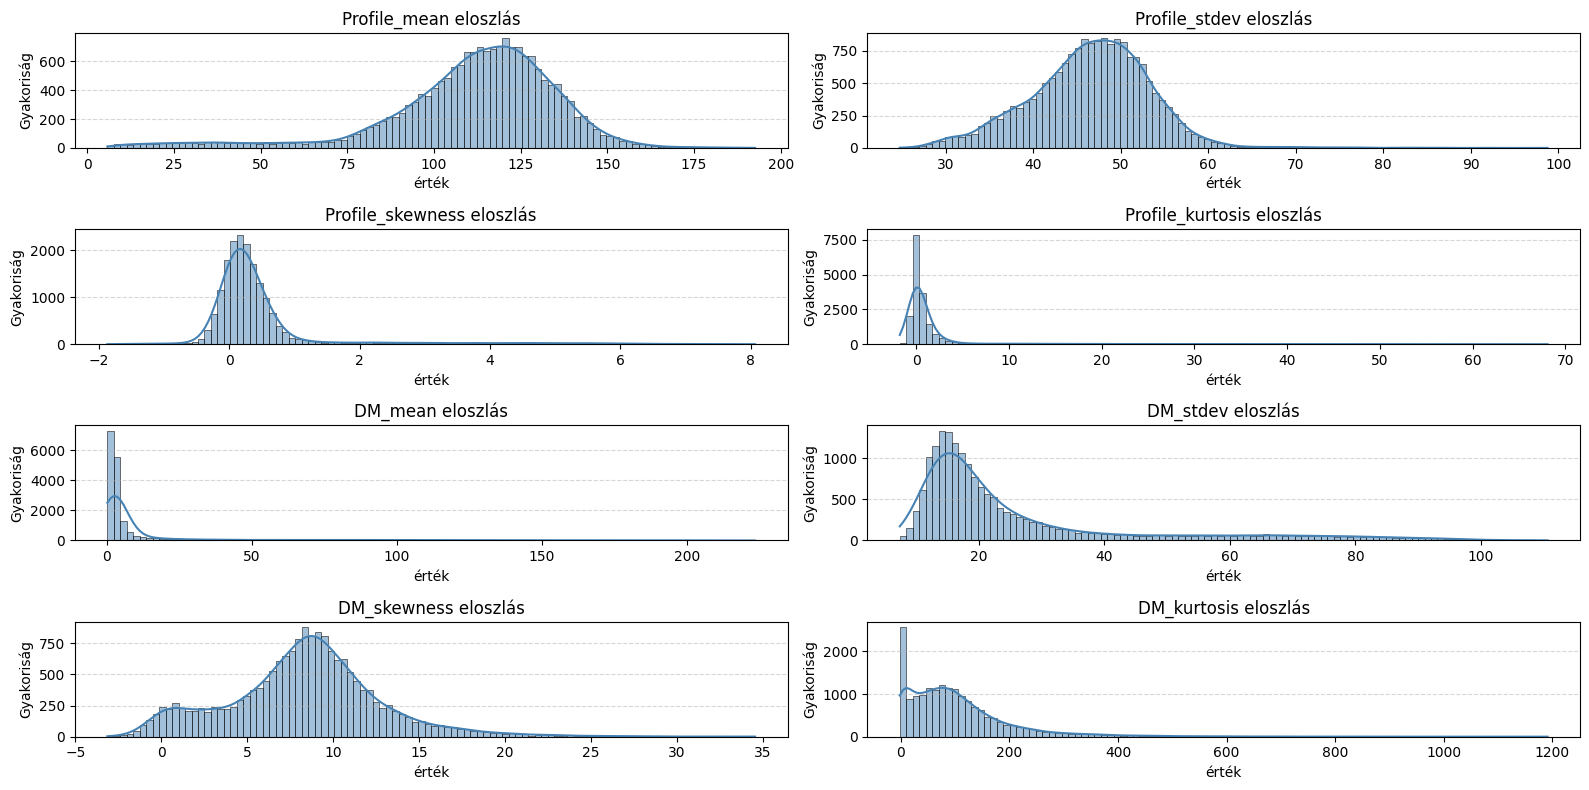

In [15]:
for i, adat in enumerate(feature_cimkek):
    j = i % len(feature_cimkek)
    if j == 0:
        fig, axes = plt.subplots(len(feature_cimkek) // 2, 2, figsize=(16, 8))
        axes = axes.flatten()
    ax = axes[j]
    sb.histplot(data=X, x=adat, kde=True, color="steelblue", ax=ax, bins=100)
    ax.set_title(f"{adat} eloszlás", fontsize=12)
    ax.set_xlabel("érték")
    ax.set_ylabel("Gyakoriság")
    ax.grid(axis="y", linestyle="--", alpha=0.5)

plt.tight_layout()
plt.show()

Mivel tudjuk, hogy az adathalmazban a "zaj" (0-s osztály) a bemeneti adatok 90%-át teszi ki, ezek a grafikonok elsősorban a 0-s osztály (zaj) eloszlását tükrözik. A ritka pulzárok (1-es osztály) adatai feltehetően elvesznek a "farkakban", a szélsőségesnek tűnő értékekben vagy a kettős csúcsokban.

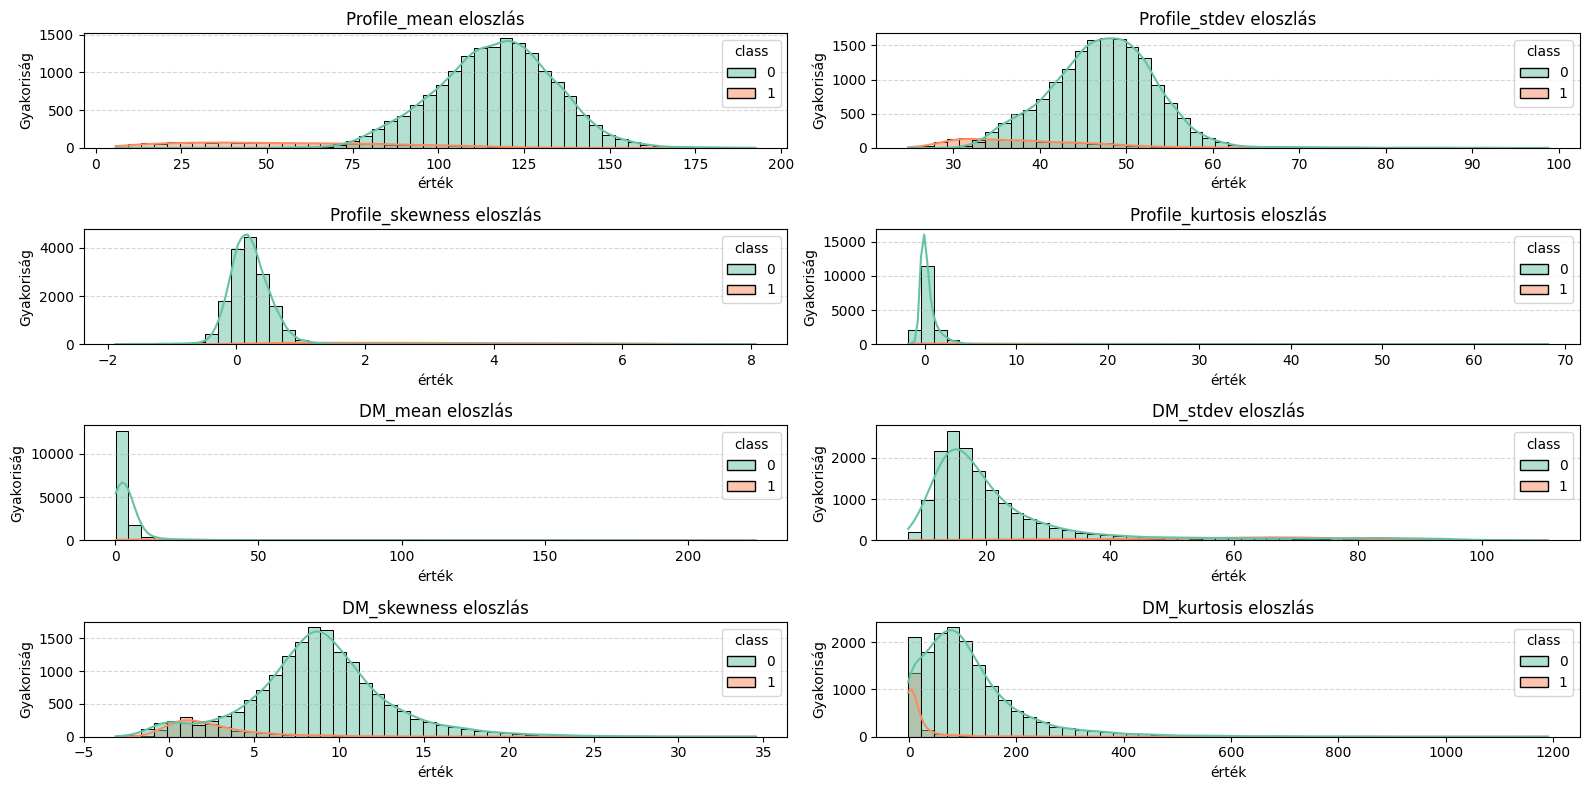

In [16]:
temp = pd.concat([X, y], axis=1)

for i, adat in enumerate(feature_cimkek):
    j = i % len(feature_cimkek)
    if j == 0:
        fig, axes = plt.subplots(len(feature_cimkek) // 2, 2, figsize=(16, 8))
        axes = axes.flatten()
    ax = axes[j]
    sb.histplot(data=temp, x=adat, hue='class', kde=True, ax=ax, bins=50, palette='Set2')
    ax.set_title(f"{adat} eloszlás", fontsize=12)
    ax.set_xlabel("érték")
    ax.set_ylabel("Gyakoriság")
    ax.grid(axis="y", linestyle="--", alpha=0.5)

plt.tight_layout()
plt.show()

Az előző feltételezéseimet ez megerősíti:
- a grafikonok elsősorban a 0-s osztály (zaj) eloszlását tükrözik
- a ritka pulzárok (1-es osztály) adatai a "farkakban" (pl. Profile_mean) és dupla csúcsokban jelennek meg (pl. DM_skewness)

Viszont a DM skewness és a DM kurtosis két csúcspontját a két osztály eltérő hisztogramja megmagyarázza.

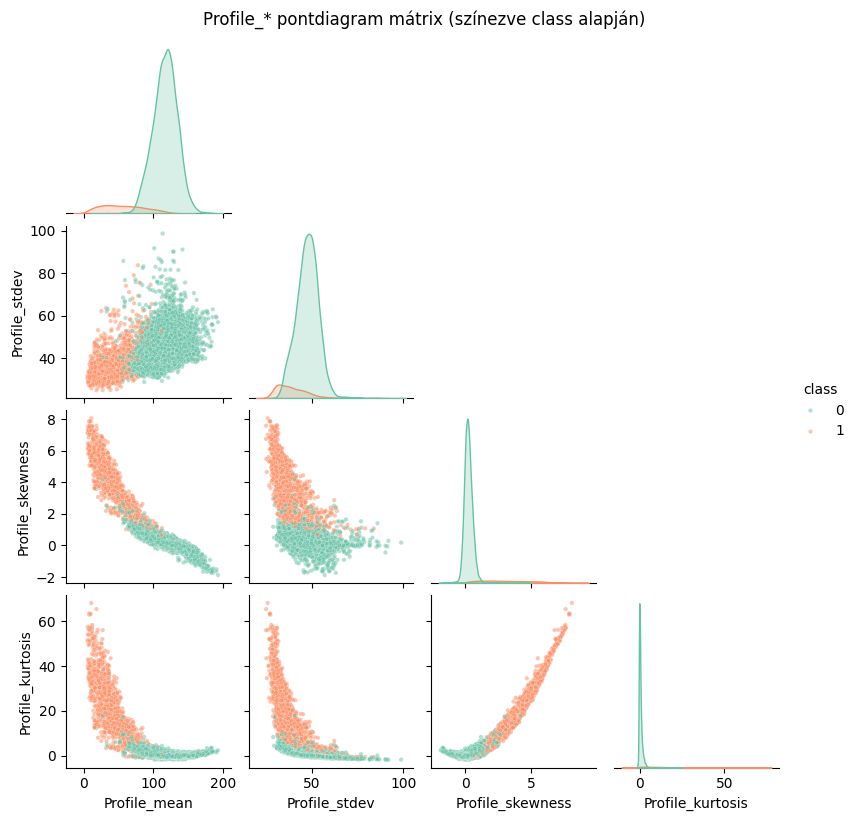

In [17]:
profile_cimkek = [c for c in feature_cimkek if c.startswith('Profile')]
sb.pairplot(pd.concat([X[profile_cimkek], y], axis=1), hue='class', diag_kind='kde', corner=True, palette='Set2', plot_kws={'s': 10, 'alpha': 0.5}, height=2)
plt.suptitle("Profile_* pontdiagram mátrix (színezve class alapján)", y=1.02)
plt.show()

Itt szerintem több változó is együtt mozog, ha nem is lineárisan. Például a skewness értékének kövekedésével a kurtosis is növekszik, vagy pl a mean növekedésével a skewness csökkenő tendenciát mutat. Azonban az egyes osztályok eléggé elkülönülnek egymástól, máshol, másként csoportosulnak.

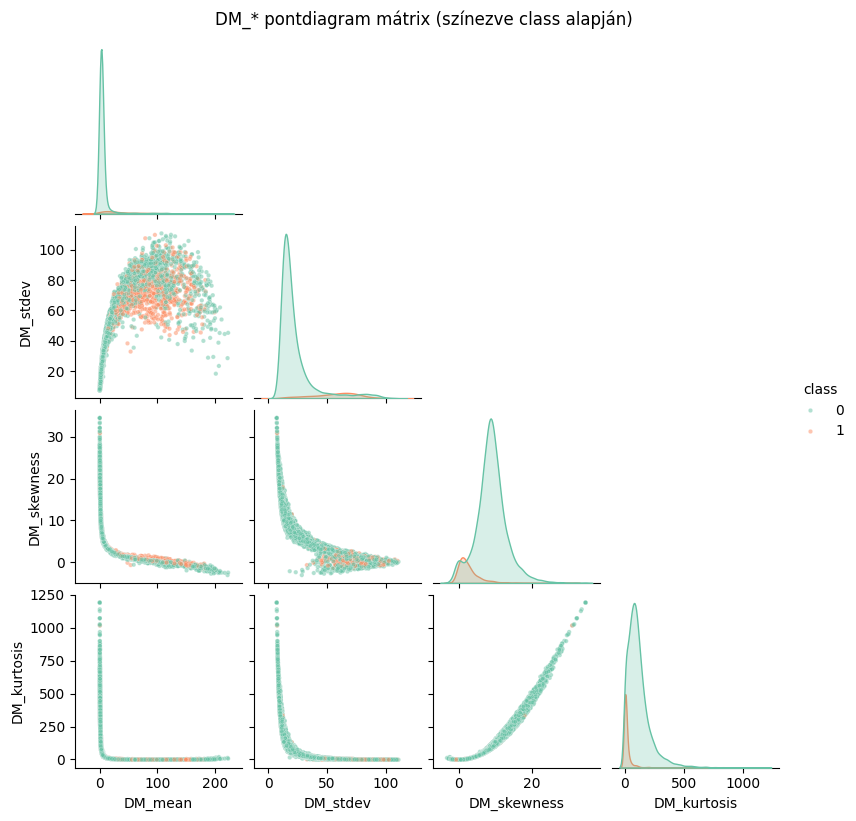

In [18]:
dm_cimkek = [c for c in feature_cimkek if c.startswith('DM')]
sb.pairplot(pd.concat([X[dm_cimkek], y], axis=1), hue="class", diag_kind="kde", corner=True, palette="Set2", plot_kws={"s": 10, "alpha": 0.5}, height=2)
plt.suptitle("DM_* pontdiagram mátrix (színezve class alapján)", y=1.02)
plt.show()

Míg a profile értékeknél "felhők"-be csoportosultak az adatok itt többnyire vékony vonalak jelennek meg. A skewness/kurtosis szinte teljesen együtt mozog. A mean 0 közeli értéke esetén azonban kurtosis és a skewness szinte bármekkora értéket felvehet.

Másrészt, itt a narancs pontok mintha inkább csak egy-egy pontba tömörülnének, szinte alig láthatóak az ábrán. Önmagukban a DM változók nehezebben választják szét a pulzárokat a zajtól, mert a pulzárok adatai (narancs) gyakran lefedik a zaj (zöld) területét is.

Összességében inkább a Profile változók mondják meg, hogy "úgy néz-e ki, mint egy pulzár", a DM változók pedig azt teszik hozzá, hogy "távolról jön-e a jel" (a zajnak szinte nincs diszperziója, ami logikus, hiszen nem távoli űrből jön, hanem feltehetően helyi zavar). A kettő együtt adja a legjobb eredményt feltehetően.

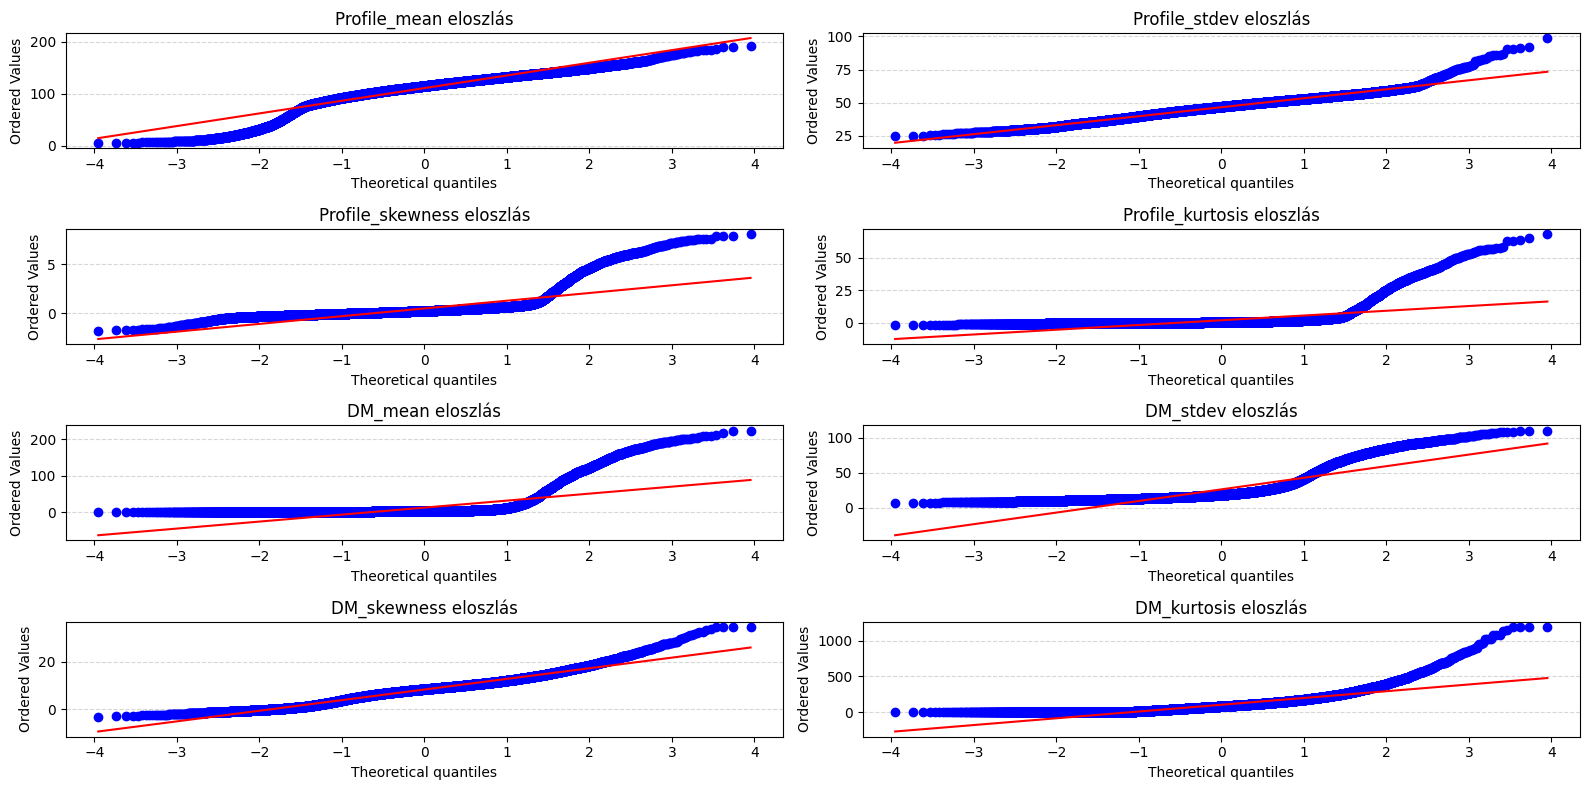

In [19]:
for i, adat in enumerate(feature_cimkek):
    j = i % len(feature_cimkek)
    if j == 0:
        fig, axes = plt.subplots(len(feature_cimkek) // 2, 2, figsize=(16, 8))
        axes = axes.flatten()
    ax = axes[j]
    stats.probplot(X[adat], dist="norm", plot=ax)
    ax.set_title(f"{adat} eloszlás", fontsize=12)
    ax.grid(axis="y", linestyle="--", alpha=0.5)

plt.tight_layout()
plt.show()

Az adatok egyáltalán nem követik a normális eloszlást. Minden egyes ábránál jelentős eltérés van a piros vonaltól.

Nem használhatok olyan algoritmusokat átalakítások nélkül, amik normális eloszlást feltételeznek. Robusztus modellek kellenek: a döntési fák, a Random Forest vagy az XGBoost sokkal jobban kezelik az ilyen "csúnya", nem normális eloszlású és kiugró értékekkel teli adatokat.

A Q-Q plotok azt mutatják, hogy az adathalmaz tele van aszimmetriával és kiugró értékekkel (valószínűleg ezek a keresett pulzárok jelei lehetnek???), és távol áll a "szép" haranggörbétől.

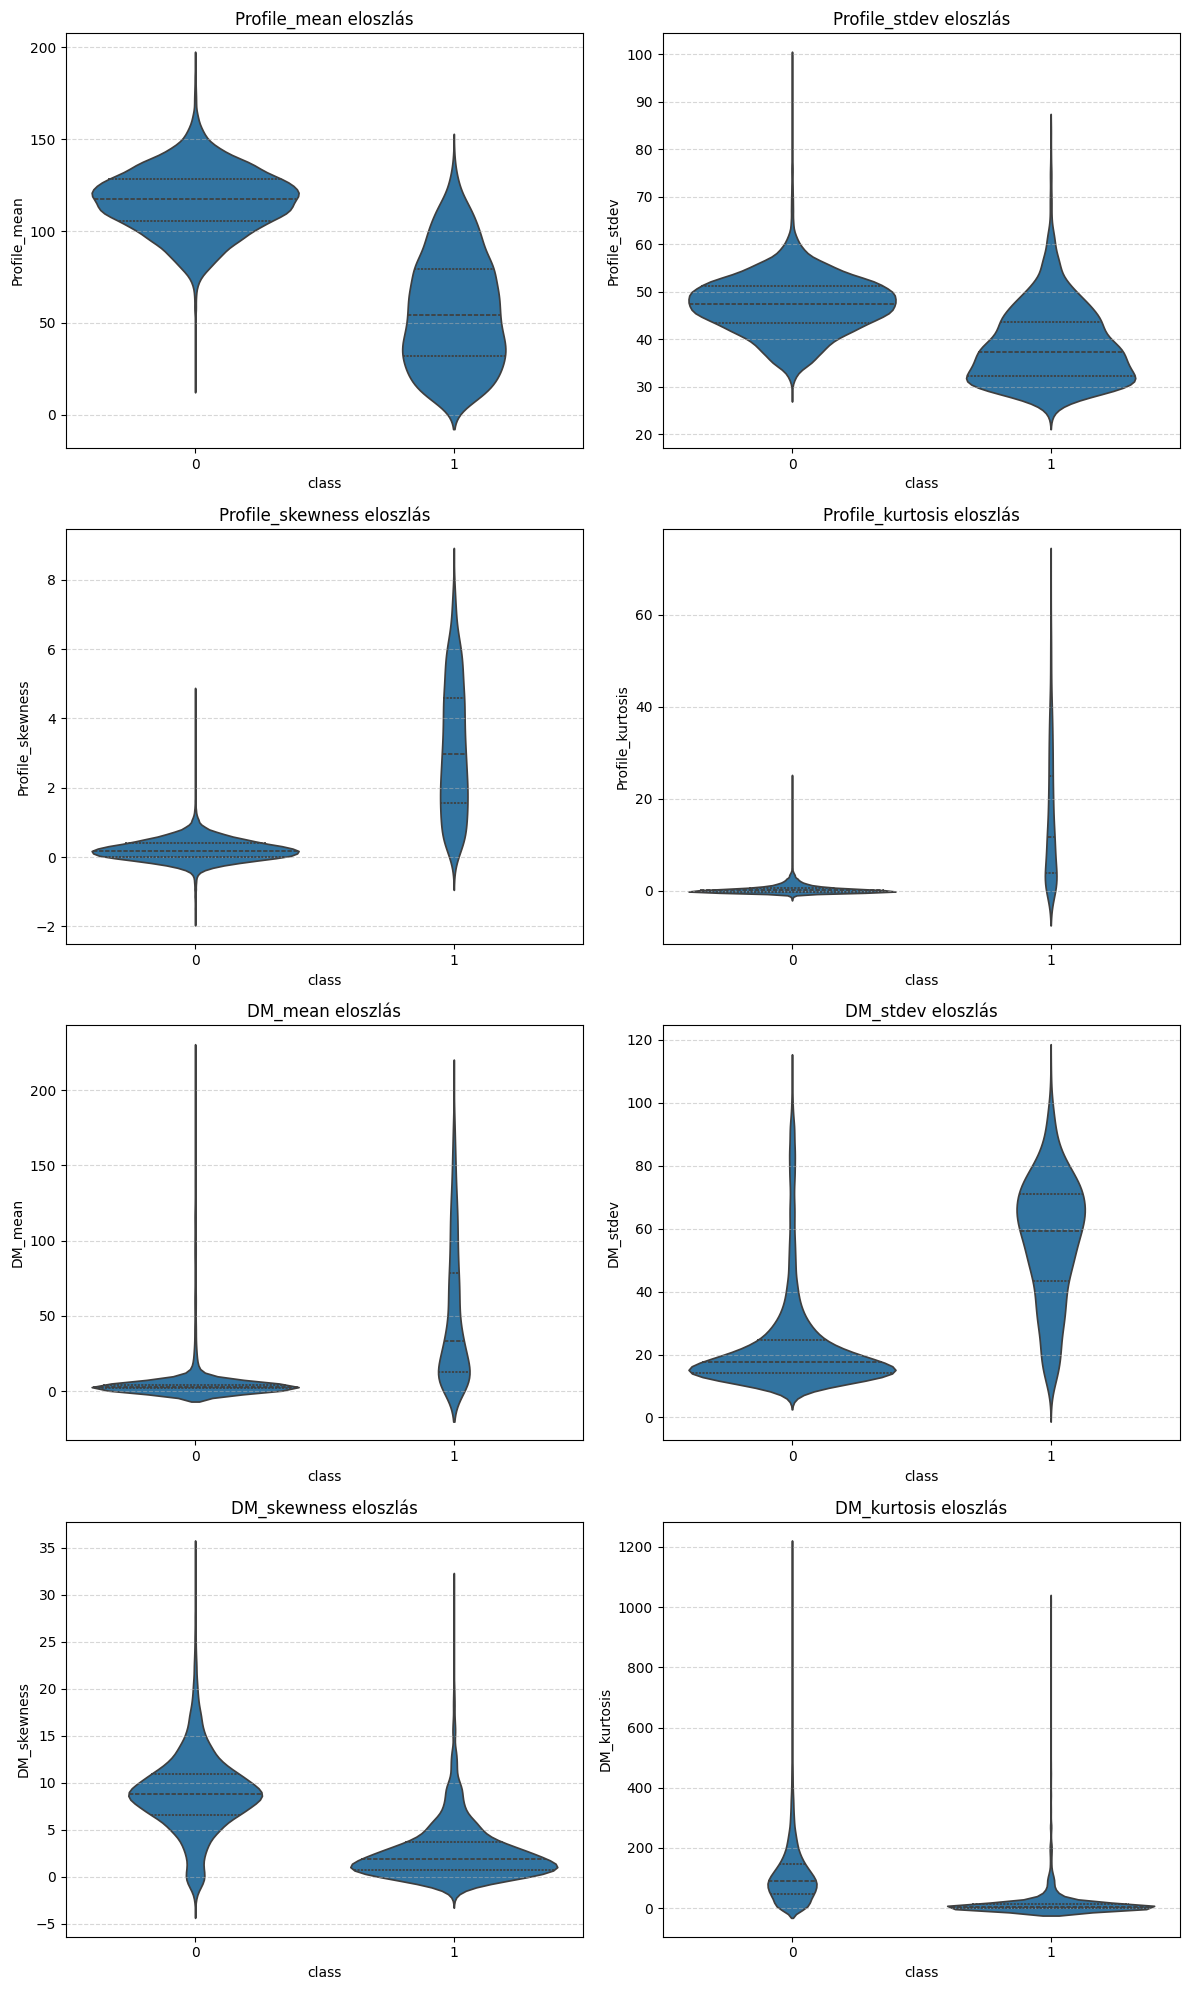

In [20]:
for i, adat in enumerate(feature_cimkek):
    j = i % len(feature_cimkek)
    if j == 0:
        fig, axes = plt.subplots(len(feature_cimkek) // 2, 2, figsize=(12, 20))
        axes = axes.flatten()
    ax = axes[j]
    sb.violinplot(data=pd.concat([X, y], axis=1), x="class", y=adat, inner="quartile", ax=ax) 
    ax.set_title(f"{adat} eloszlás", fontsize=12)
    ax.grid(axis="y", linestyle="--", alpha=0.5)

plt.tight_layout()
plt.show()

**Profile_mean (Átlag)**
- 0-s osztály: Magasabb értékek körül tömörül (kb. 100-120).
- 1-es osztály: Alacsonyabb értékek (kb. 40-60).
- A két osztály jól elkülönül, a pulzárok profiljának átlaga alacsonyabb.

**Profile_stdev (Szórás)**
- Kisebb az eltérés, de a 0-s osztálynak valamivel magasabb és szélesebb eloszlása van, mint az 1-esnek.

**Profile_skewness (Ferdeség)**
- 0-s osztály: 0 közelében van, szimmetrikus eloszlás.
- 1-es osztály: Magas pozitív értékek.
- Ez egy nagyon erős megkülönböztető jellemző. A pulzárok jele aszimmetrikus.

**Profile_kurtosis (Csúcsosság)**
- Hasonló a ferdeséghez: a 0-s osztály lapos (0 körüli), míg az 1-es osztály nagyon csúcsos (magas értékek).
- Ez is élesen szétválasztja a két csoportot.

**DM_mean és DM_stdev**
- 0-s osztály: Nagyon kicsi értékeknél, a 0 közelében tömörülnek (a hegedű alja széles).
- 1-es osztály: Sokkal nagyobb szórást és magasabb átlagértékeket mutatnak.
- A pulzárok (1) DM értékei változatosabbak és magasabbak.

**DM_skewness és DM_kurtosis**
- Itt a helyzet fordított, mint a Profile esetében. A 0-s osztály mutat nagyobb értékeket és szórást, míg az 1-es osztály értékei alacsonyabb tartományban mozognak.

**A két osztály eloszlásai jelentősen eltérnek** </br>
Szinte minden változón jól látható, hogy a 0 és 1 osztály eloszlásai nem fedik egymást teljesen. Ez azt jelenti, hogy az adott jellemzők valóban informatívak lehetnek az osztály elkülönítésére, az adathalmaz jó alap egy klasszifikációs modellhez.

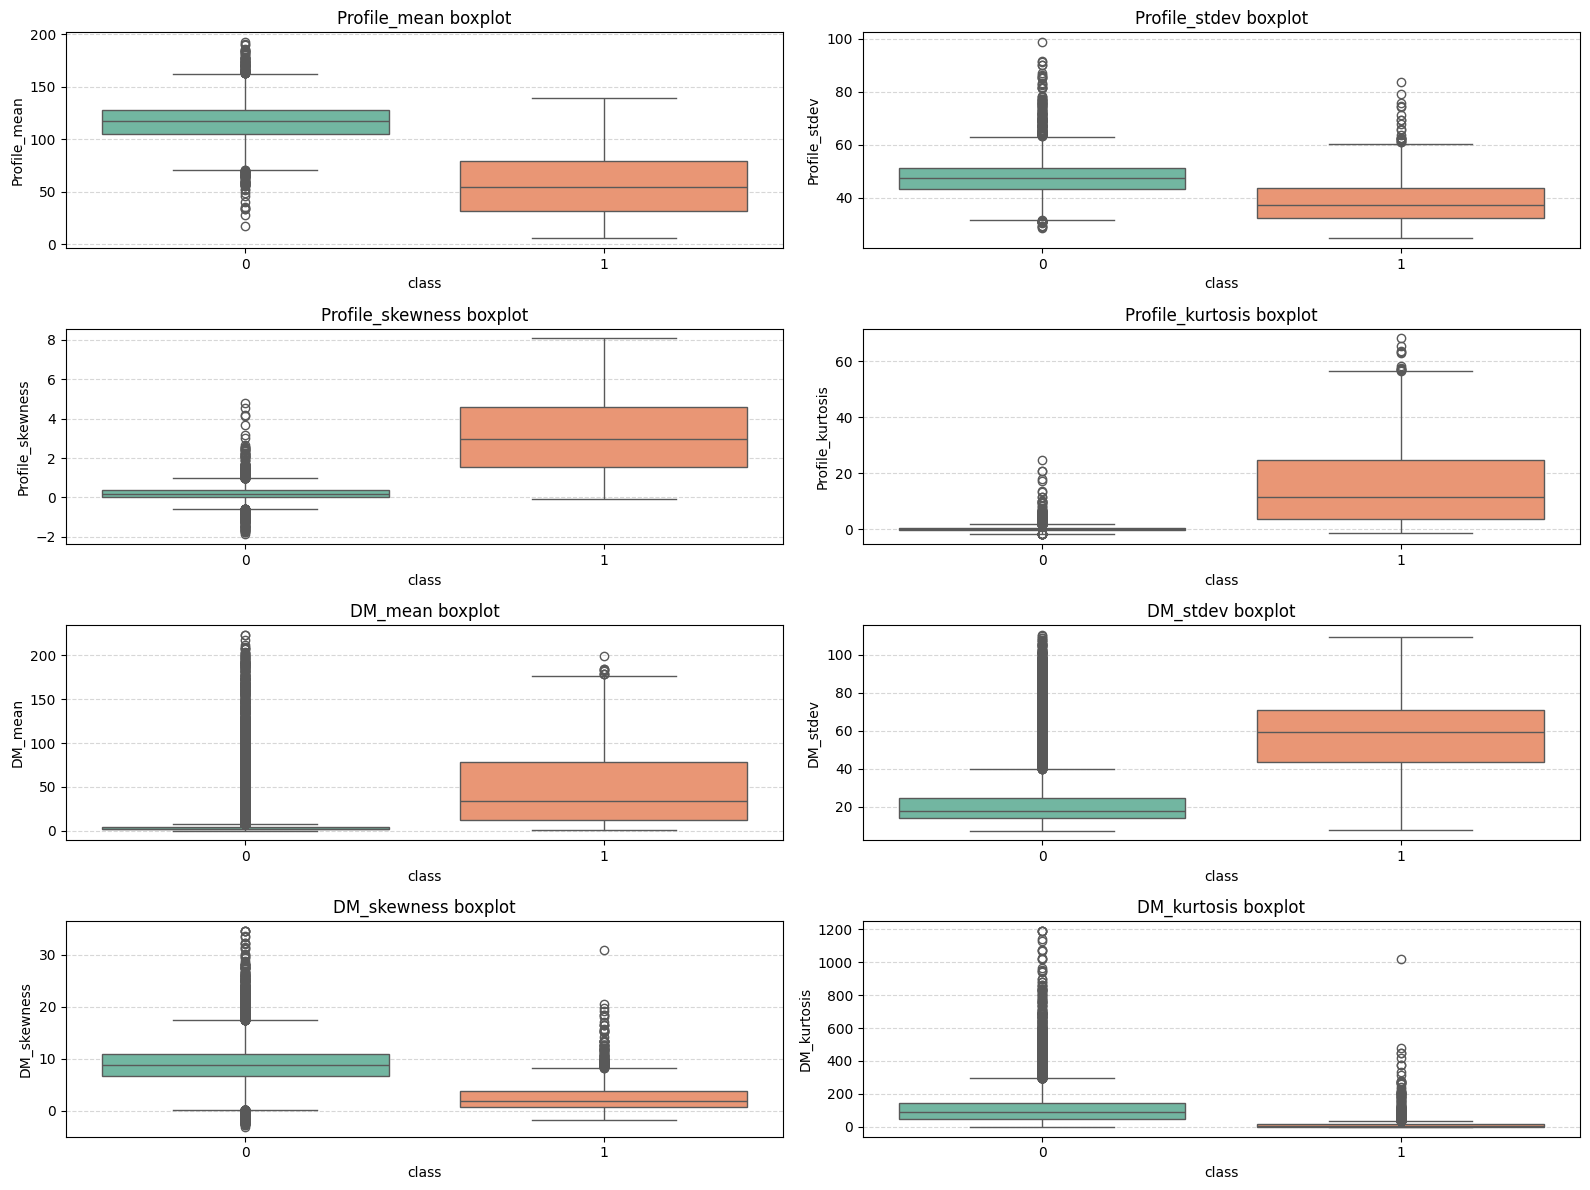

In [21]:
temp = pd.concat([X, y], axis=1)

fig, axes = plt.subplots(4, 2, figsize=(16, 12))
axes = axes.flatten()

for i, adat in enumerate(feature_cimkek):
    sb.boxplot(data=temp, x="class", y=adat, hue="class", palette="Set2", legend=False, ax=axes[i])
    axes[i].set_title(f"{adat} boxplot", fontsize=12)
    axes[i].grid(axis="y", linestyle="--", alpha=0.5)

plt.tight_layout()
plt.show()

A boxplotok alapján a szélsőértékek extrémek és torzítják a skálát és főleg a class 0 (nem pulzár) esetében jelentősek. Legtöbb esetben a pulzárokat leíró adatok interquartilis terjedelme nagyobb és kevesebb outliert tartalmaznak, míg a nem pulzárként cimkézett adatok bár stabilabbak, jobban tömörülnek egy érték körül, de sokkal nagyobbak a kiugró értékek és sokkal több is van belőlük.

Talán a legérdekesebb adatok a Profile_skewness és/vagy a Profile_kurtosis lehetne, mert itt az értékek annyira elkülönülnek egymástól, hogy akár 1-1 vágással is el tudnák különíteni az adatokat.

# Összefüggés vizsgálat

A Pearson-korreláció ebben az esetben nem lesz megfelelő, mert az adatok egyáltalán nem követnek normális eloszlást. Ezért a Spearman-féle rangkorrelációt vizsgálom.

In [22]:
X.corr(method='spearman').style.format("{:.2}").background_gradient(cmap=plt.get_cmap('coolwarm'), axis=None)

,Profile_mean,Profile_stdev,Profile_skewness,Profile_kurtosis,DM_mean,DM_stdev,DM_skewness,DM_kurtosis
Profile_mean,1.0,0.5,-0.88,-0.64,-0.077,-0.09,0.081,0.085
Profile_stdev,0.5,1.0,-0.5,-0.88,0.0071,-0.0046,0.0026,0.0054
Profile_skewness,-0.88,-0.5,1.0,0.66,0.087,0.1,-0.089,-0.093
Profile_kurtosis,-0.64,-0.88,0.66,1.0,0.065,0.078,-0.072,-0.075
DM_mean,-0.077,0.0071,0.087,0.065,1.0,0.95,-0.99,-0.99
DM_stdev,-0.09,-0.0046,0.1,0.078,0.95,1.0,-0.95,-0.97
DM_skewness,0.081,0.0026,-0.089,-0.072,-0.99,-0.95,1.0,0.99
DM_kurtosis,0.085,0.0054,-0.093,-0.075,-0.99,-0.97,0.99,1.0


**Profile_mean – Profile_skewness**
- –0.88, ez erős negatív írányú kapcsolat, az egyik változó növekedésével a másik csökken

**Profile_stdev – Profile_kurtosis**
- –0.88, ez erős negatív írányú kapcsolat

**Profile_kurtosis -  Profile_mean**
- -0.635, közepes negatív irányú kapcsolat

**Profile_stdev - Profile_skewness**
- -0.5, közepes negatív irányú kapcsolat

**Profile_skewness - Profile_kurtosis**
- 0.66, közepes pozitív irányú kapcsolat, az egyik változó kövekedésével a másik is növekszik

**Profile_mean - Profile_stdev**
- 0.5, közepes pozitív irányú kapcsolat

**DM adatok**
- Tulajdonképpen a diszperziós értéket leíró adatok közül bármely kettőt vesszük, azok erősen összefüggésben vannak egymással. Talán a 4 változó helyettesíthető csak eggyel is? Mert eléggé úgy tűnik, hogy ugyan azt az információt írják le. Aminek egyébként van értelme, mert ez a 4 változó azt írja le, hogy a jel a Földről származik vagy sem (pl. rádiófrekvenciás zaj a földről).

**DM és Profile**
- A korrelációs mátrix alapján mindenhol elmondható, hogy a két adatcsoportot leíró változók között nincs összefüggés.

In [23]:
correlations = X.corrwith(y["class"], method='spearman').abs().sort_values(ascending=False)
print(correlations)

Profile_skewness    0.471799
Profile_mean        0.451022
Profile_kurtosis    0.440875
DM_stdev            0.394253
DM_mean             0.392615
DM_kurtosis         0.386499
DM_skewness         0.384472
Profile_stdev       0.312819
dtype: float64


A célváltozóval a legjobban a DM_stdev korrelál a DM_* adatok közül, ezért a többi mező szerintem elhagyható a DM_* adatcsoportból. A Profile_* adatcsoportból a Profile_mean és Profile_stdev elhagyása egy lehetséges megoldás az erős korrelációk megszüntetésére.

# Adattisztítás

## Multikollinearitás megszüntetése

Ezt az előző adatok alapján kézzel fogom megtenni azon tulajdonságok eltávolításával, amelyek feltehetően nem hordoznak hasznos extra információt a többi tulajdonsághoz képest.

In [24]:
X_original = X.copy()
y_original = y.copy()

X = X.drop(columns=["Profile_mean", "Profile_stdev", "DM_mean", "DM_skewness", "DM_kurtosis"])

## Outlierek

A statisztikai adatok alapján egyértelmű, hogy az outlierek eltávolítása szükséges, de ez nem olyan egyszerű, mert a pulzár osztály minden outlierét nem távolíthatom el . Azért nem, mert ezek az értékes adatok, kevés van belőlük és egyáltalán nem biztos, hogy outlierek, lehet, hogy egy a többi pulzártól eltérő de valós adat, ami akár egy különleges felfedezés is lehet. Ezért a zajból fogom eltávolítani az outliereket, mert abból sok adat van és azokból adatok eltávolítása nem fogja tovább rontani az adathalmaz kiegyensúlyozatlanságát.

In [25]:
def remove_outliers_iqr(X, y, multiplier=1.5):
    Q1 = X.quantile(0.25)
    Q3 = X.quantile(0.75)
    IQR = Q3 - Q1
    mask = ~((X < (Q1 - multiplier * IQR)) | (X > (Q3 + multiplier * IQR))).any(axis=1)
    return X[mask], y[mask]

In [26]:
X_class0 = X[y['class'] == 0]
y_class0 = y[y['class'] == 0]

X_class1 = X[y['class'] == 1]
y_class1 = y[y['class'] == 1]

X_clean_class1, y_clean_class1 = remove_outliers_iqr(X_class0, y_class0, 1.5)

X_clean = pd.concat([X_clean_class1, X_class1])
y_clean = pd.concat([y_clean_class1, y_class1])

In [27]:
X_clean.describe()

,Profile_skewness,Profile_kurtosis,DM_stdev
count,15188.000000,15188.000000,15188.000000
mean,0.502803,1.867721,22.564115
std,1.127025,6.640883,14.760299
min,-0.563544,-1.501641,7.370432
25%,0.030240,-0.185080,14.152679
50%,0.215549,0.174722,17.638717
75%,0.437320,0.769144,24.400043
max,8.069522,68.101622,109.655345


In [28]:
y["class"].value_counts(), y_clean["class"].value_counts()

(class
 0    16259
 1     1639
 Name: count, dtype: int64,
 class
 0    13549
 1     1639
 Name: count, dtype: int64)

In [29]:
16259-13549

2710

Az outlierek eltávolítása a zaj (class=0) osztály elemeinek számát 2710-el csökkentette. Ennek előnye az outlierek eltávolításán túl, hogy nem csak a kiegyensúlyozatlanság csökkent kis mértékben, de megmaradtak az értékes osztály adatai.

## Normalitás

In [30]:
def normalitas_ellenorzes(df):
    results = []
    
    for col in df.columns:
        data = df[col]
        stat, p = kstest(data, 'norm', args=(np.mean(data), np.std(data)))
        
        results.append({
            'Változó': col,
            'P-érték': p,
            'Normális eloszlású?': 'IGEN' if p > 0.05 else 'NEM',
            'Statisztika': stat
        })
    
    results_df = pd.DataFrame(results)
    return results_df

In [31]:
normalitas_eredmenyek = normalitas_ellenorzes(X_clean)
normalitas_eredmenyek

,Változó,P-érték,Normális eloszlású?,Statisztika
0,Profile_skewness,0.0,NEM,0.318032
1,Profile_kurtosis,0.0,NEM,0.403301
2,DM_stdev,0.0,NEM,0.207565


Ez megerősíti az ábrákon látottakat, hogy egyik változó sem normális eloszlású. Ennek kezelésére a power transformert használom a yeo-johnsom módszerrel, mert negatív értékek is vannak az adathalmazban. Az adatszivárgás elkerülése érdekében csak a train adatokon történik a fit, a test adatokon már csak transform művelet fut.

In [32]:
X_train, X_test, y_train, y_test = train_test_split(X_clean, y_clean, test_size=0.33, stratify=y_clean)

In [33]:
pt = PowerTransformer(method='yeo-johnson', standardize=True)
X_train_ptft = pt.fit_transform(X_train)
X_test_ptft = pt.transform(X_test)
X_train_ptft = pd.DataFrame(X_train_ptft, columns=X_train.columns, index=X_train.index)
X_test_ptft = pd.DataFrame(X_test_ptft, columns=X_test.columns, index=X_test.index)

In [34]:
feature_cimkek = list(X.columns)
feature_cimkek

['Profile_skewness', 'Profile_kurtosis', 'DM_stdev']

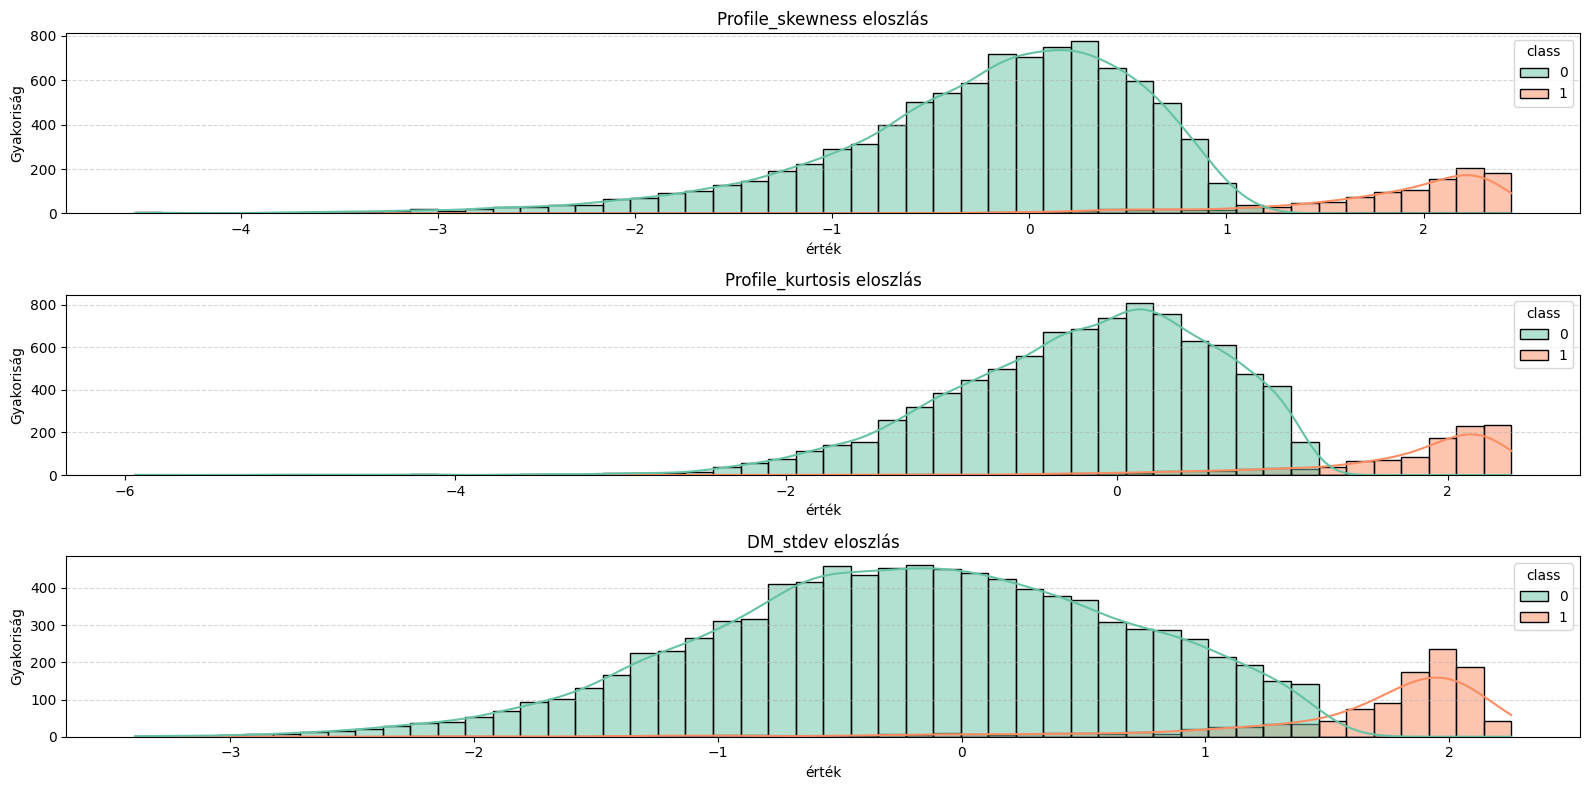

In [35]:
temp = pd.concat([X_train_ptft, y_train], axis=1)

for i, adat in enumerate(feature_cimkek):
    j = i % len(feature_cimkek)
    if j == 0:
        fig, axes = plt.subplots(len(feature_cimkek), 1, figsize=(16, 8))
        axes = axes.flatten()
    ax = axes[j]
    sb.histplot(data=temp, x=adat, hue='class', kde=True, ax=ax, bins=50, palette='Set2')
    ax.set_title(f"{adat} eloszlás", fontsize=12)
    ax.set_xlabel("érték")
    ax.set_ylabel("Gyakoriság")
    ax.grid(axis="y", linestyle="--", alpha=0.5)

plt.tight_layout()
plt.show()

A tökéletes normális eloszlást nem tudtam ezzel elérni, de ennek oka az ábrákon is látható, mivel mostmár nagyon elkülönülnek a két osztály grafikonjai.

## Skálázás

A RobustScaler a mediánt és az IQR-t használja a skálázáshoz. Így a szélső értékek nem fogják "összenyomni" a görbe közepét. Itt is követem azt a módszert, hogy a fit csak a teszt adatokon történik, hogy az adatszivárgás ne okozzon gondot.

In [36]:
rs = RobustScaler()
X_train_ptft_rs = rs.fit_transform(X_train_ptft)
X_test_ptft_rs = rs.transform(X_test_ptft)
X_train_ptft_rs = pd.DataFrame(X_train_ptft_rs, columns=X_train_ptft.columns, index=X_train_ptft.index)
X_test_ptft_rs = pd.DataFrame(X_test_ptft_rs, columns=X_test_ptft.columns, index=X_test_ptft.index)

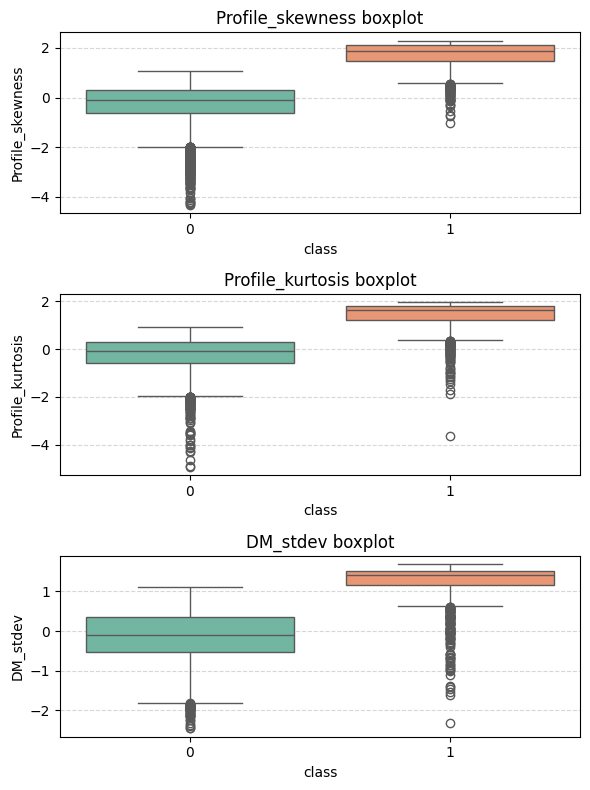

In [37]:
temp = pd.concat([X_train_ptft_rs, y_train], axis=1)

fig, axes = plt.subplots(3, 1, figsize=(6, 8))
axes = axes.flatten()

for i, adat in enumerate(feature_cimkek):
    sb.boxplot(data=temp, x="class", y=adat, hue="class", palette="Set2", legend=False, ax=axes[i])
    axes[i].set_title(f"{adat} boxplot", fontsize=12)
    axes[i].grid(axis="y", linestyle="--", alpha=0.5)

plt.tight_layout()
plt.show()

# Oversampling

A kiegyensúlyozatlan adathalmaz miatt alkalmazom, szintén csak a train adatokon a random oversamplert.

In [38]:
rand_os = RandomOverSampler(random_state=42)

X_train, y_train = rand_os.fit_resample(X_train_ptft_rs, y_train)
X_test = X_test_ptft_rs.copy()

print('X mérete az oversampling előtt: ', X_train_ptft_rs.shape)
print('X mérete az oversampling után: ', X_train.shape)

print('\nSzázalékos osztályeloszlás a kiegyensúlyozott adathalmazban:')
df_y_randos = pd.DataFrame(y_train)
df_y_randos.value_counts(normalize=True) * 100

X mérete az oversampling előtt:  (10175, 3)
X mérete az oversampling után:  (18154, 3)

Százalékos osztályeloszlás a kiegyensúlyozott adathalmazban:


class
0        50.0
1        50.0
Name: proportion, dtype: float64

# Osztályozás

Szerintem itt tudományos kutatási szempontból az lenne a jó, ha esetleg több téves riasztás van, akkor is a valódi pulzárokat minél nagyobb arányban eltalálná a modell.

## Döntési fa (nyers adatok)

Ezt kizárólag csak azért csinálom meg a nyers adatokon, hogy legyen valami kiinduló alapom, "baseline" az összehasonlításhoz (hogy pl. mennyit számítot az adatok átalakítása). Ezt elvileg megtehetem, mert a döntési fa nem érzékeny az outlierekre és nem követeli meg a normalitást és a skálázást.

In [39]:
dtc = DecisionTreeClassifier(class_weight="balanced", random_state=42)

In [40]:
dtc.fit(X, y)

,criterion,'gini'
,splitter,'best'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,42
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,class_weight,'balanced'


In [41]:
y_pred = dtc.predict(X_test)

In [42]:
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Sensitivity:", recall_score(y_test, y_pred))
print("Specificity:", recall_score(y_test, y_pred, pos_label=0))
print("F1:", f1_score(y_test, y_pred))
print("AUC:", roc_auc_score(y_test, y_pred))

Accuracy: 0.943147815679234
Sensitivity: 0.5268022181146026
Specificity: 0.993515205724508
F1: 0.6666666666666666
AUC: 0.7601587119195553


In [43]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.95      0.99      0.97      4472
           1       0.91      0.53      0.67       541

    accuracy                           0.94      5013
   macro avg       0.93      0.76      0.82      5013
weighted avg       0.94      0.94      0.94      5013



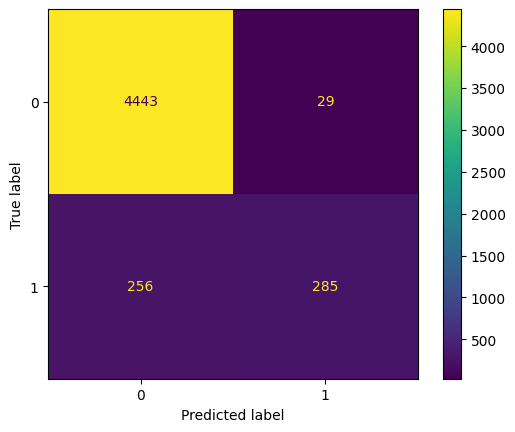

In [44]:
confmatrix = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(confusion_matrix=confmatrix).plot()

A modell kiválóan teljesít a nagyobb osztály esetében. Szinte minden 0-s predikció pontos, és az esetek szinte mindegyikét megtalálja. A kisebb osztály esetében a teljesítménye gyakorlatilag random válaztást jelent.

## Döntési fa (tisztított adatok)

Itt már a tisztított adatokon fogok dolgozni.

In [45]:
dtc = DecisionTreeClassifier(random_state=42)
dtc.fit(X_train,y_train)
y_pred = dtc.predict(X_test)
print(classification_report(y_test, y_pred))
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Sensitivity:", recall_score(y_test, y_pred))
print("Specificity:", recall_score(y_test, y_pred, pos_label=0))
print("F1:", f1_score(y_test, y_pred))
print("AUC:", roc_auc_score(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      4472
           1       0.93      0.92      0.92       541

    accuracy                           0.98      5013
   macro avg       0.96      0.96      0.96      5013
weighted avg       0.98      0.98      0.98      5013

Accuracy: 0.9834430480750049
Sensitivity: 0.9205175600739371
Specificity: 0.9910554561717353
F1: 0.9230769230769231
AUC: 0.9557865081228363


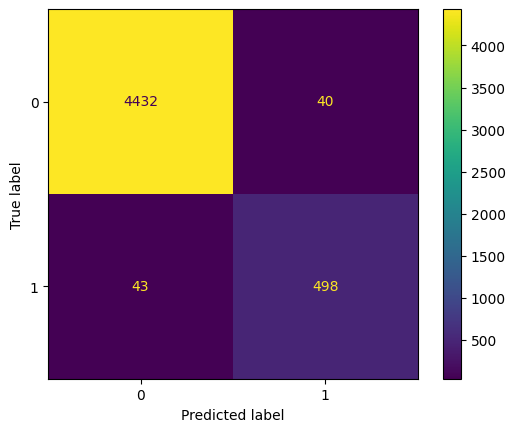

In [46]:
confmatrix = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(confusion_matrix=confmatrix).plot()

A tisztított adatokon természetesen a modell sokat javult, és mostmár egyáltalán nem random a kisebbségi kategória meghatározása, sőt, egészen pontos.

In [47]:
dot_data = export_graphviz(dtc, out_file=None,
                      feature_names=feature_cimkek,
                      class_names=["Died", "Survived"],
                      filled=True,
                      rounded=True,
                      special_characters=True)
graph = graphviz.Source(dot_data)
#graph

## Logisztikus regresszió

A logisztikus regresszió jó választás lehet az adathalmaz tekintetében osztályozási feladatra, mert az osztálycimkék kétértékűek, a változók folytonos változók és valószínűséget ad, nem csak kategóriákat. A multikollinearitást megszüntettem, így szerintem nincs akadálya a modell használatának.

In [48]:
lr = LogisticRegression(random_state=42)
lr.fit(X_train, y_train["class"])
y_pred = lr.predict(X_test)
print(classification_report(y_test, y_pred))
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Sensitivity:", recall_score(y_test, y_pred))
print("Specificity:", recall_score(y_test, y_pred, pos_label=0))
print("F1:", f1_score(y_test, y_pred))
print("AUC:", roc_auc_score(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.99      0.97      0.98      4472
           1       0.82      0.93      0.87       541

    accuracy                           0.97      5013
   macro avg       0.90      0.95      0.93      5013
weighted avg       0.97      0.97      0.97      5013

Accuracy: 0.9696788350289248
Sensitivity: 0.9279112754158965
Specificity: 0.9747316636851521
F1: 0.8685121107266436
AUC: 0.9513214695505243


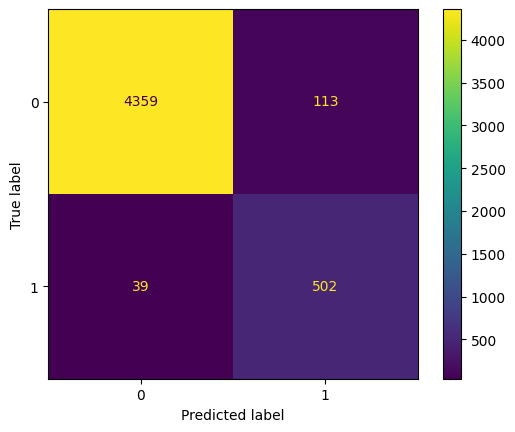

In [49]:
confmatrix = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(confusion_matrix=confmatrix).plot()

A false negativ ertekek itt a legkisebbek eddig, de a probléma az, hogy nagyon megugrott a false pozitív értékek száma. Az valóban cél, hogy a kisebbségi osztály jól legyen azonosítva, de nem ilyen áron.

## Random forest

Mivel ez sok döntési fa szavazata alapján dönt ("ensemble" módszer), kiválóan kezelhetii a pulzárokra jellemző zajos adatokat és a kiugró értékeket anélkül, hogy túlságosan megtanulná a hibákat (overfitting). A páros diagramokon láttuk, hogy az összefüggések bonyolultak és nem mindig egyenesek; a Random Forest képes ezeket a nem-lineáris mintázatokat is lekövetni.

In [50]:
rfc = RandomForestClassifier(random_state=42)
rfc.fit(X_train, y_train["class"])
y_pred = rfc.predict(X_test)
print(classification_report(y_test, y_pred))
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Sensitivity:", recall_score(y_test, y_pred))
print("Specificity:", recall_score(y_test, y_pred, pos_label=0))
print("F1:", f1_score(y_test, y_pred))
print("AUC:", roc_auc_score(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99      4472
           1       0.99      0.92      0.95       541

    accuracy                           0.99      5013
   macro avg       0.99      0.96      0.97      5013
weighted avg       0.99      0.99      0.99      5013

Accuracy: 0.9900259325753042
Sensitivity: 0.9168207024029574
Specificity: 0.9988819320214669
F1: 0.9520153550863724
AUC: 0.9578513172122123


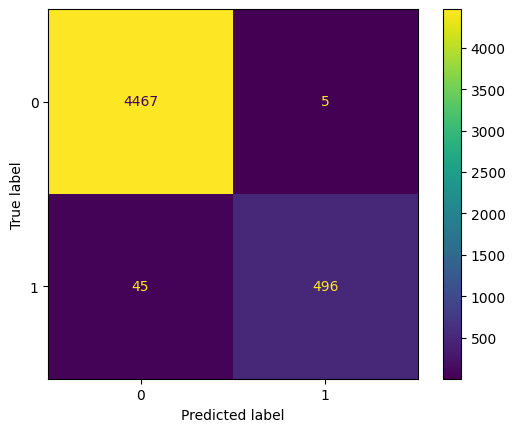

In [51]:
confmatrix = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(confusion_matrix=confmatrix).plot()

A random forest már alapbeállításokkal is nagyon jó mutatókat eredményezett, különösen a false pozitív értékek javultak számottevően.

## Support vector machine

A Profile_kurtosis és skewness ábráin látszott, hogy a pulzárok egy jól körülhatárolható, de szabálytalan alakú "szigetet" alkotnak, az SVM  az ilyen szigetszerű elkülönülések megtalálásában segíthet. Érzékeny az összefüggő adatokra, de ezeket már megszüntettem.

In [52]:
svcl = SVC(kernel='rbf', random_state=42)
svcl.fit(X_train, y_train["class"])
y_pred = svcl.predict(X_test)
print(classification_report(y_test, y_pred))
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Sensitivity:", recall_score(y_test, y_pred))
print("Specificity:", recall_score(y_test, y_pred, pos_label=0))
print("F1:", f1_score(y_test, y_pred))
print("AUC:", roc_auc_score(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      4472
           1       0.94      0.92      0.93       541

    accuracy                           0.99      5013
   macro avg       0.97      0.96      0.96      5013
weighted avg       0.99      0.99      0.99      5013

Accuracy: 0.9852383802114503
Sensitivity: 0.9168207024029574
Specificity: 0.993515205724508
F1: 0.9305816135084428
AUC: 0.9551679540637328


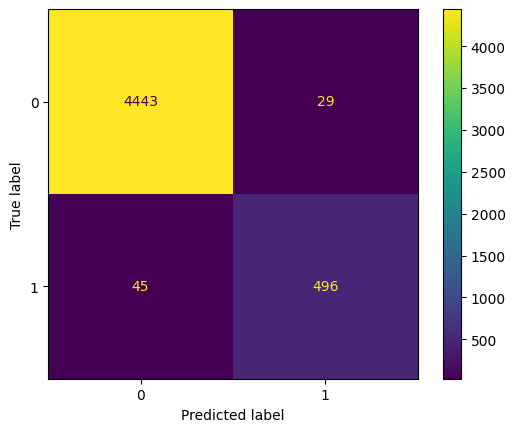

In [53]:
confmatrix = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(confusion_matrix=confmatrix).plot()

Többé kevésbé alapbeállítások mellett ez a modell sem szerepelt rosszul. Azonban teljesítménye elmarad a random forest mögött.

## Modellek összehasonlítása

A kiegyensúlyozatlan adathalmaz miatt a Precision-Recall görbét használom.

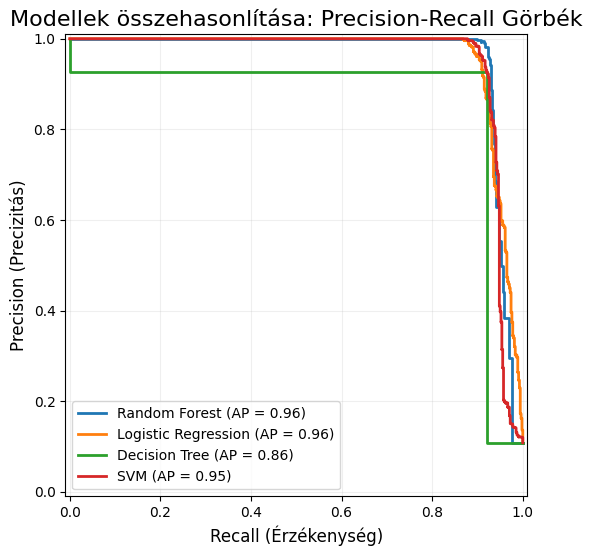

In [54]:
fig, ax = plt.subplots(figsize=(10, 6))

models = [
    (rfc, "Random Forest"),
    (lr, "Logistic Regression"),
    (dtc, "Decision Tree"),
    (svcl, "SVM"),
]

for model_object, model_name in models:
    PrecisionRecallDisplay.from_estimator(
        estimator=model_object,
        X=X_test,
        y=y_test,
        name=model_name,
        ax=ax,
        linewidth=2
    )

plt.title("Modellek összehasonlítása: Precision-Recall Görbék", fontsize=16)
plt.xlabel("Recall (Érzékenység)", fontsize=12)
plt.ylabel("Precision (Precizitás)", fontsize=12)
plt.legend(loc="best", fontsize=10)
plt.grid(True, alpha=0.2)
plt.show()

Az nem meglepő hogy a döntési fa szerepelt a legrosszabbul. A Random forest a legjobb választás, mert precision gyakorlatilag egyen tartása mellett a legmagasabb recall értéket tudta elérni.

## Hyperparaméterek hangolása

A fenti gyorstesztek alapján a random forestet választottam a hyper paraméter hangolásra, mert sokféle paramétert lehet hangolni és eleve jól teljesített. A futásidők és a számítási erőforrás hiányában csak a RandomizedSearchCV-t fogom használni.

Scoringnak az average_precision-t választottam, mivel szeretnék a pozitív osztályra (pulzár) és a téves riasztásokra koncentrálni. A "szénakazlat" (a rengeteg helyesen felismert zajt) ez teljesen figyelmen kívül hagyja.

5 fold crossvalidationt használok, ennek oka leginkább a szükséges számítási erőforrás limitáltsága.

In [55]:
rfch = RandomForestClassifier(random_state=42)
params = {
    'criterion': ['gini', 'entropy'],
    'n_estimators': range(100, 1000),
    'max_depth': range(1, 25),
    'min_samples_split': range(2, 20),
    'min_samples_leaf': range(1, 10),
    'max_features': ['sqrt', 'log2', None],
    'bootstrap': [True, False]
}

random_search = RandomizedSearchCV(
    estimator=rfch,
    param_distributions=params,
    n_iter=100,
    cv=5,
    scoring='average_precision',
    n_jobs=-1,
    verbose=2,
    random_state=42
)

random_search_results = random_search.fit(X_train, y_train["class"])

print(f"Legjobb paraméterek: {random_search.best_params_}")
print(f"Legjobb Average Precision score (Train CV): {random_search.best_score_:.4f}")

best_rf_model = random_search.best_estimator_

Fitting 5 folds for each of 100 candidates, totalling 500 fits
[CV] END bootstrap=False, criterion=gini, max_depth=1, max_features=sqrt, min_samples_leaf=6, min_samples_split=8, n_estimators=288; total time=   0.7s
[CV] END bootstrap=False, criterion=gini, max_depth=1, max_features=sqrt, min_samples_leaf=6, min_samples_split=8, n_estimators=288; total time=   0.7s
[CV] END bootstrap=False, criterion=gini, max_depth=1, max_features=sqrt, min_samples_leaf=6, min_samples_split=8, n_estimators=288; total time=   0.7s
[CV] END bootstrap=False, criterion=gini, max_depth=1, max_features=sqrt, min_samples_leaf=6, min_samples_split=8, n_estimators=288; total time=   0.7s
[CV] END bootstrap=False, criterion=gini, max_depth=1, max_features=sqrt, min_samples_leaf=6, min_samples_split=8, n_estimators=288; total time=   0.8s
[CV] END bootstrap=True, criterion=entropy, max_depth=7, max_features=log2, min_samples_leaf=3, min_samples_split=18, n_estimators=592; total time=   4.5s
[CV] END bootstrap=Tru

In [56]:
y_pred = best_rf_model.predict(X_test)
print(classification_report(y_test, y_pred))
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Sensitivity:", recall_score(y_test, y_pred))
print("Specificity:", recall_score(y_test, y_pred, pos_label=0))
print("F1:", f1_score(y_test, y_pred))
print("AUC:", roc_auc_score(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99      4472
           1       0.99      0.92      0.95       541

    accuracy                           0.99      5013
   macro avg       0.99      0.96      0.97      5013
weighted avg       0.99      0.99      0.99      5013

Accuracy: 0.9900259325753042
Sensitivity: 0.9186691312384473
Specificity: 0.9986583184257602
F1: 0.9521072796934866
AUC: 0.9586637248321037


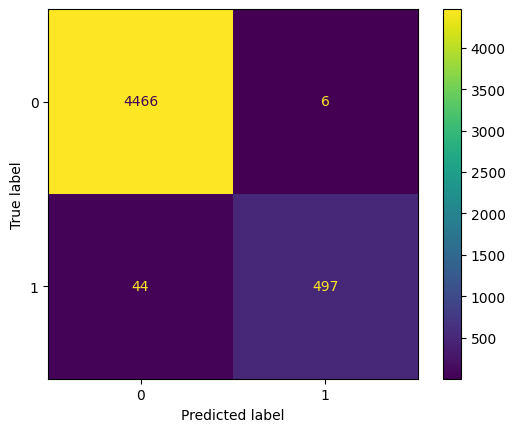

In [57]:
confmatrix = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(confusion_matrix=confmatrix).plot()

A hyperparaméterekkel hangolt modell képességei a megfelelő irányba mozdultak el, a fals negatív értékek száma csökkent. Ugyan nagyon minimálisan a false pozitív esetek száma növekedett, de ez egy megfelelő kromposszimum az adatok jellegét tekintve.

# Jellemzők szelekciója

In [58]:
perm_importance = permutation_importance(
    best_rf_model, 
    X_test,
    y_test, 
    n_repeats=10, 
    random_state=42, 
    scoring='average_precision'
)

sorted_idx = perm_importance.importances_mean.argsort()

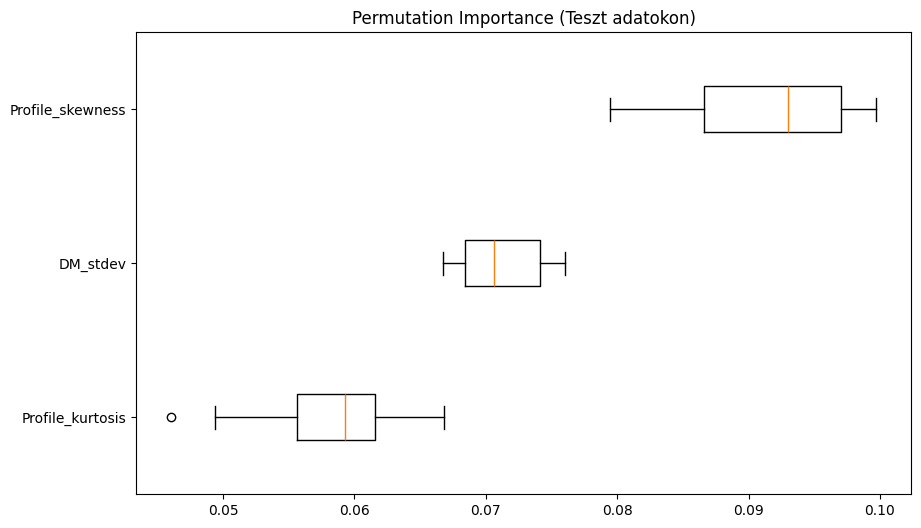

In [59]:
plt.figure(figsize=(10, 6))
plt.boxplot(
    perm_importance.importances[sorted_idx].T,
    vert=False,
    tick_labels=X_test.columns[sorted_idx]
)
plt.title("Permutation Importance (Teszt adatokon)")
plt.show()

A Permutation Importance (permutációs fontosság) azt mutatja meg, hogy mennyit romlana a modell pontossága, ha az adott változót véletlenszerűen összekevernénk. Jól látszik, hogy mindhárom megmaradt változónak van szerepe, nem gondolom, hogy legkevésbé jelentős a DM_stdev eltávolítható lenne, de ennek igazolására egy feature szelekciót fogok futtatni.

## Szekvenciális feature szelekció

Az előzőekben megtalált hangolt hyperparaméterek:

{'n_estimators': 803, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 18, 'criterion': 'gini', 'bootstrap': False}

In [60]:
sfs = SFS(best_rf_model,
          k_features = 'best',
          forward = False,
          floating = True,
          scoring = 'average_precision',
          cv = 5,
          n_jobs = -1)
sfs = sfs.fit(X_train, y_train["class"])

print('Sequential forward selection (%i features): ' % np.size(sfs.k_feature_idx_)) # a kiválasztott tulajdonságok száma
print('A választott tulajdosnágok indexe: ', sfs.k_feature_idx_)
print('CV score: ', sfs.k_score_)

Sequential forward selection (3 features): 
A választott tulajdosnágok indexe:  (0, 1, 2)
CV score:  0.9999979371125092


In [61]:
feature_cimkek_sfs = [feature_cimkek[i] for i in sfs.k_feature_idx_]
feature_cimkek_sfs

['Profile_skewness', 'Profile_kurtosis', 'DM_stdev']

A visszafelé haladó lebegő szekvenciális kiválasztás (SFFS) megerősítette a kézi feature selection döntéseket: mind a három változót (Profile_skewness, Profile_kurtosis, DM_stdev) megtartotta, és a CV score 0.9999 lett. Ez azt jelenti, hogy az eredetileg 8 változóból kiválasztott 3 változó optimális, a korábban eltávolított multikollineáris változók (Profile_mean, Profile_stdev, DM_mean, DM_skewness, DM_kurtosis) valóban redundánsak voltak. További változó eltávolítása rontaná a modell teljesítményét.

In [62]:
best_rf_model.feature_importances_

f_imp = zip(feature_cimkek, best_rf_model.feature_importances_)
rf_imp = pd.DataFrame(f_imp, columns = ['feature', 'importance']).sort_values(axis=0, by='importance', ascending=False)
rf_imp

,feature,importance
0,Profile_skewness,0.361729
1,Profile_kurtosis,0.328777
2,DM_stdev,0.309494


Ezek alapján mindhárom modell releváns a modell teljesítménye szempontjából, a fontossági értékek kiegyensúlyozottak.

A kiválasztott változók jól illeszkednek a pulzárok fizikai jellemzőihez:
- Profile_skewness (legfontosabb): A pulzárok jelének aszimmetriája - a valódi pulzárjelek karakterisztikusan ferde profillal rendelkeznek, míg a zaj inkább szimmetrikus lehet
- Profile_kurtosis: A jel csúcsossága - a pulzárok éles, csúcsos jeleket produkálnak
- DM_stdev: A diszperziós mérték variabilitása - a távoli űrből érkező jelek más diszperziós mintázatot mutatnak, mint a helyi eredetű zaj

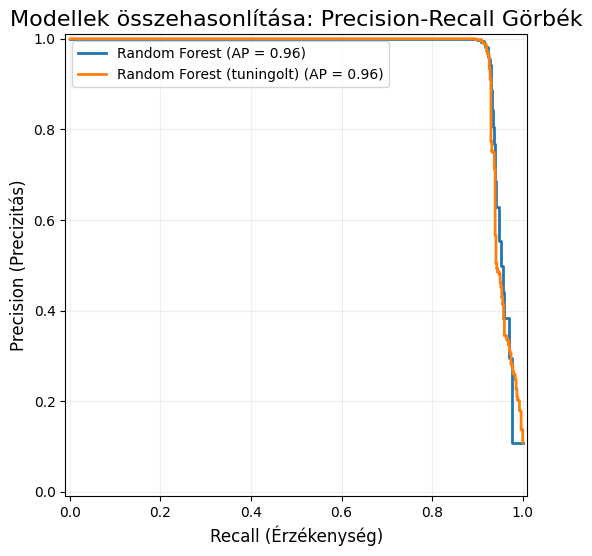

In [63]:
fig, ax = plt.subplots(figsize=(10, 6))

models = [
    (rfc, "Random Forest"),
    (best_rf_model, "Random Forest (tuningolt)"),
]

for model_object, model_name in models:
    PrecisionRecallDisplay.from_estimator(
        estimator=model_object,
        X=X_test,
        y=y_test,
        name=model_name,
        ax=ax,
        linewidth=2
    )

plt.title("Modellek összehasonlítása: Precision-Recall Görbék", fontsize=16)
plt.xlabel("Recall (Érzékenység)", fontsize=12)
plt.ylabel("Precision (Precizitás)", fontsize=12)
plt.legend(loc="best", fontsize=10)
plt.grid(True, alpha=0.2)
plt.show()

# Support vector machine hyperparamétereinek tuningolása

Jelentős javulást nem sikerült elérni, ezért megnézem, hogy az SVM-em sikerül-e elérni nagyobb mértékű javulást.

In [ ]:
svmh = SVC(random_state=42)
params_svm = {
    'C': [0.1, 1, 10, 100, 1000],
    'gamma': ['scale', 'auto', 0.001, 0.01, 0.1, 0.2, 0.5, 1],
    'kernel': ['rbf', 'poly'],
    'degree': [2, 3, 4, 5, 6, 7],  # csak poly kernel esetén releváns
}

random_search_svm = RandomizedSearchCV(
    svmh,
    param_distributions=params_svm,
    n_iter=100,
    cv=5,
    scoring='average_precision',
    n_jobs=-1,
    verbose=2,
    random_state=42
)

random_search_results_svm = random_search_svm.fit(X_train, y_train["class"])

print(f"Legjobb paraméterek: {random_search_svm.best_params_}")
print(f"Legjobb Average Precision score (Train CV): {random_search_svm.best_score_:.4f}")

best_svm_model = random_search_svm.best_estimator_

Fitting 5 folds for each of 100 candidates, totalling 500 fits
[CV] END ............C=0.1, degree=6, gamma=0.1, kernel=poly; total time=   1.4s
[CV] END ............C=0.1, degree=6, gamma=0.1, kernel=poly; total time=   1.4s
[CV] END ............C=0.1, degree=6, gamma=0.1, kernel=poly; total time=   1.6s
[CV] END ............C=0.1, degree=6, gamma=0.1, kernel=poly; total time=   1.5s
[CV] END ............C=0.1, degree=6, gamma=0.1, kernel=poly; total time=   1.6s
[CV] END ..............C=1000, degree=3, gamma=1, kernel=rbf; total time=   4.6s
[CV] END ..............C=1000, degree=3, gamma=1, kernel=rbf; total time=   4.9s
[CV] END ..............C=1000, degree=3, gamma=1, kernel=rbf; total time=   5.2s
[CV] END ............C=1000, degree=2, gamma=0.2, kernel=rbf; total time=   3.6s
[CV] END ............C=1000, degree=2, gamma=0.2, kernel=rbf; total time=   3.7s
[CV] END ............C=1000, degree=2, gamma=0.2, kernel=rbf; total time=   3.8s
[CV] END ..............C=1000, degree=3, gamma

# Összegzés

A vizsgálat célja az HTRU2 adatbázis alapján pulzárok és zaj (nem-pulzár jelek) elkülönítése volt felügyelt gépi tanulási módszerekkel. Az adathalmaz erősen kiegyensúlyozatlan: 16259 zajminta mellett mindössze 1639 valódi pulzár szerepel benne (kb. 10:1 arány).

Az exploratív adatelemzés során kiderült, hogy az adatok nem követnek normális eloszlást, jelentős outliereket tartalmaznak, és erős multikollinearitás áll fenn a változók között. A Spearman-korreláció vizsgálata rámutatott, hogy a Profile és DM változócsoportokon belül több változó is redundáns információt hordoz.

Az adattisztítás során a multikollinearitás megszüntetése érdekében az eredeti 8 változóból 3-at tartottam meg: Profile_skewness, Profile_kurtosis és DM_stdev. Az outlierek eltávolítását csak a zajadatokon végeztem el, megőrizve a ritka pulzárokat. A normalitás javítására Yeo-Johnson power transzformációt, majd RobustScaler skálázást alkalmaztam. A kiegyensúlyozatlanság kezelésére RandomOverSampler-t használtam a tanító adatokon.

Négy klasszifikációs modellt teszteltem: döntési fa, logisztikus regresszió, Random Forest és SVM. A nyers adatokon futtatott baseline döntési fa gyenge teljesítményt mutatott a kisebbségi osztályon (53% sensitivity, 0.76 AUC), míg a tisztított adatokon a modellek jelentősen javultak. A Random Forest bizonyult a legjobb választásnak, alapbeállításokkal is 92% sensitivity-t (a pozitívak helyesen felismert arányát) ért el.

A RandomizedSearchCV-vel végzett hiperparaméter-hangolás további javulást eredményezett: a végső modell 99% accuracy mellett 93% sensitivity-t és 0.96 AUC-t produkált. A permutációs fontosság és a szekvenciális feature szelekció megerősítette, hogy mindhárom kiválasztott változó releváns és szükséges a modell optimális működéséhez.

**Következtetések:** A pulzárok sikeres azonosításához a profil aszimmetriája (skewness) és csúcsossága (kurtosis), valamint a diszperziós mérték variabilitása (DM_stdev) a legfontosabb jellemzők.